# "Галя, у нас отмена": предсказание отмены резервирования номеры в отеле

**Контекст**

Для проекта было использован датасет [Hotel Booking demand](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand?resource=download&select=hotel_bookings.csv), доступный на платформе Kaggle. Этот набор данных представляет собой предобработанную версию оригинального датасета, описанного в \[[Antonio et al., 2019](https://www.sciencedirect.com/science/article/pii/S2352340918315191)\]. Первоначальные данные были получены авторами с помощью SQL-запроса к системе PMS (Property Management System), которая используется отелями для управления бронированиями.

Как отмечают авторы оригинального датасета [Antonio et al., 2019], отели сталкиваются с рядом критических проблем при планировании бизнес-стратегии, связанных с неопределенностью (а порой с непредсказуемостью) поведения гостей. Вот самые критичные моменты:
1. Отмены бронирований в последний момент, что приводит к:
 * потере доходов: освободившиеся номера не успевают занять новые гости, так как они уже выбрали другие варианты
 * простою ресурсов: отель теряет прибыль из-за неоптимальной загрузки (номера, за которые никто не платит, продолжают отапливаться и содержаться в чистоте за счет труда горничных; в итоге новой прибыли нет, а накопленные ранее ресурсы продолжают тратиться)
2. Изменение условий бронирования перед заездом (изменение числа гостей в номере, добавление или отмена дополнительные услуг), что создает:
 * логистические сложности (например, нехватку мест в ресторане при резком росте числа завтраков)
 * финансовые риски (непредсказуемость затрат на обслуживание).

Основная задача проекта, таким образом, разработать модель для hotel demand forecasting (прогнозирование спроса на номера). Продуктивно работающая модель машинного обучения позволит отелям:
* оценивать риски пере- или недобронирования
* оптимизировать ценообразование
* задавать условия наличия/отсутствия предоплаты в зависимости от конкретных факторов
* повышать эффективность работы за счет прогнозирования загрузки отелей

In [6]:
!pip install catboost optuna plotly

In [7]:
# импорт необходимых библиотек
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, \
balanced_accuracy_score
from sklearn.pipeline import make_pipeline

from scipy.stats import loguniform

from yellowbrick.model_selection import FeatureImportances

from lightgbm import LGBMClassifier, cv
import catboost

import optuna

import numpy as np

import pickle

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly

In [61]:
# функции для сохранения объектов
def save_bnr(obj_to_save, bnr_path):
    with open(bnr_path, 'wb') as f:
        pickle.dump(obj_to_save, f)

def load_bnr(bnr_path):
    with open(bnr_path, 'rb') as f:
        object_loaded = pickle.load(f)
    return object_loaded

In [88]:
def save_model(model, model_type, is_crossval=False, dataset_name):
    model_info = {"model_id": f"{model=}",
                  "model_type": model_type,

                  "cross_validation": {
                      "used": is_crossval,
                      "strategy": "Optuna"},

                  "dataset": dataset_name,

                  "metrics": {
                      "accuracy": 0.89,
                      "precision": 0.85,
                      "recall": 0.82,
                      "f1": 0.835,
                      "roc_auc": 0.91}}


SyntaxError: incomplete input (<ipython-input-88-1577672646>, line 1)

In [9]:
random_num = 9

## 1. Загрузка данных, EDA

**Представленные переменные**

В датасете представлены следующие переменные:

**Таргет**: `is_canceled` - была ли бронь отменена или нет

**Фичи**:

* **Числовые:**
 * *Непрерывные:*
   1. `adr`: Average Daily Rate: сколько в среднем гость отдает за номер
 * *Дискретные:*
   2. `adults`: количество взрослых, указанных в брони
   3.`babies`: количество малышей, указанных в брони
   4. `booking_changes`: количество изменений, которые сделал в брони гость (количество гостей, дата прибытия и т.п .)
   5. `days_in_waiting_list`: количество дней, которое гость провел в листе ожидания (то есть кол-во дней от даты резерва до даты подтверждения от отеля)
   6. `children`: количество детей, указанных в брони
   7. `lead_time`: количество дней, прошедших с дня брони до дня предполагаемого заселения
   8. `stays_in_weekend_nights`: количество ночей на выходных, которые гости проводили/собирались проводить в отеле
   9. `stays_in_week_nights`: количество ночей в будние дни, которые гости проводили/собирались проводить в отеле
   10. `total_of_special_requests`: количество специальных запросов от гостей (тип кровати, верхний этаж и т.п.)
   11. `previous_bookings_not_canceled`: количеств раз перед текущим бронированием, когда другое бронирование не было отменено
   12. `previous_cancellations`: количеств раз перед текущим бронированием, когда другое бронирование было отменено
   13. `required_car_parking_spaces`: количество парковочных мест, запрошенных клиентом
* **Качественные:**
 * *Бинарные*:
   14. `is_repeated_guest`: был ли гость до этого в отеле
   15. `hotel`: категориальная: тип отеля (resort/city, про это см. пункт 1.1)
 * *Категориальные*:
   16. `agent`: ID агенства, которое делало резервирование
   17. `arrival_date_year`: год, за который собраны данные (2015-2017)
   18. `arrival_date_month`: месяц брони
   19. `arrival_date_week_number`: номер недели в году
   20. `assigned_room_type`: тип комнаты, в которую гостя заселили
   21. `arrival_date_day_of_month`: первый день брони
   22. `company`: ID компании/сущности, которая сделала букинг и/или оплатила его
   23. `country`: страна, гражданином которой гость является
   24. `customer_type`: тип клиента (Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking)
   25. `deposit_type`: вносился ли какой-то депозит и если да, то какой (No Deposit - не вносился; Refundable - если депозит был возвратным и был меньше стоимости за все; non-refund - депозит был внесен в полном размере и затем не возвращался)
   26. `distribution_channel`: канал сбыта (TA - “Travel Agents”, “TO” - “Tour Operators”)
   27. `meal`: тип питания (Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)
   28. `market_segment` - сегмент рынка (TA/TO)
   29. `reserved_room_type`: тип комнаты, которую гость резервировал (может отличаться от `assigned_room_type` по разным причинам)
   30. `reservation_status`: статус гостя (выселился, не въехал и т. п.)
   31. `reservation_status_date`: дата последнего статуса

In [10]:
# загрузим наш датасет и посмотрим на типы данных;
# как можно увидеть, они в целом соответствуют тому, что бы мы ожидали там увидеть

sharing_url = "https://drive.google.com/file/d/1G_TRC9hQhTbnTrirs0H8bPwoz1q7fzeT/view?usp=drive_link"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]
hotel_dataset_file = pd.read_csv(download_url)
hotel_dataset_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## 1.1. Особенности датасета

Перед визуализацией распределения таргетов заметим несколько особенностей датасета относительно нашей задачи:
1. Оригинальный датасет на самом деле является комбинацией из двух других: в одном собраны данные о городских отелях, в другом - о курортных. В отельном бизнесе эти два вида несколько отличаются друг от друга: например, в resort hotel будет больше всяких facilities типа аквапарка и прочего, и туда в большинстве своем приезжают именно за отдыхом. В свою очередь, city hotel - это именно про отели внутри города, и тут больше процент людей, останавливающихся там на время командировок (или туристов с другими запросами). С т.з. бизнеса, эти задачи по-хорошему должны решаться двумя отдельными моделями. Я решила поступить следующим образом: обучать три типа моделей - resort_subset, city_subset и hotel_subset (где собрано все), чтобы потом сравнить результаты.
2. Нам необходимо создать модель, использующую в качестве предикторов только те данные, которые доступны до момента отмены или подтверждения брони, исключив показатели, не соответствующие этому условию или дублирующие информацию о таргете. Иначе говоря, надо исключить:
 * `assigned_room_type`: если гость отменил бронирование, то мы не знаем, были ли несовпадения в том, какой номер он бронировал, и тот, в который его в итоге заселили
 * `reservation_status` и `reservation_status_date`: эти данные можно использовать для анализа других составляющих (например, если гость выселился раньше, чем планировал, то интересно посмотреть, что на это могло повлиять)
3. Есть несколько фичей по времени: `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number`, `arrival_date_day_of_month`. При feature-engeneering после обучения бейзлайна надо бы подумать, что с ними делать.

In [11]:
# посмотрим также на наличие (отсутствие) пропущенных значений
hotel_isna = dict(hotel_dataset_file.isna().sum())
for key in hotel_dataset_file:
    if hotel_isna[key] != 0:
        print(key, hotel_isna[key])

children 4
country 488
agent 16340
company 112593


У нас добавилось еще несколько фичей, в которых пропущены значения. Для двух (`country` и `children`) количество пропущенных значений не настолько значимое; давайте для `children` укажем 0 везде, где NA, а строки со странами в целом опустим.

Сложнее ситуация с `agent` и `company`: там количество строк, где есть пропущенные значения, значительно больше. Это может быть связано с тем, что бронь не всегда происходит через какого-то агента/компанию, зачастую гость делает ее напрямую. Можно было бы целиком убрать эти колонки, но мы сделаем немного иначе: добавим к ним новый лейбл 0, который указывает как раз на категорию гостей, которые не использовали company/agent. Проверим, что у нас нет 0 в изначальных лейблах:

In [12]:
print(sum(hotel_dataset_file.agent == 0))
print(sum(hotel_dataset_file.company == 0))

0
0


Отлично! Тогда последние штрихи перед визуализацией

In [13]:
# исключаем 3 указанные колонки
hotel_dataset = hotel_dataset_file.drop(columns=['reservation_status', 'reservation_status_date', 'assigned_room_type'])

# исключаем строки, где пропущены значения по странам
hotel_dataset = hotel_dataset.dropna(subset=['country'])

# заполняем оставшееся нулями
hotel_dataset.fillna({'children': 0, 'company': 0, 'agent': 0}, inplace=True)


In [14]:
# снова проверяем наличие пропущенных значений
hotel_dataset.isna().values.any()

np.False_

In [15]:
len(hotel_dataset)

118902

In [16]:
# создаем еще два датасета, с которыми дальше будем работать; из двух уберем колонку с типом отеля
resort_subset = hotel_dataset[hotel_dataset.hotel == 'Resort Hotel'].drop(columns=['hotel'])
city_subset = hotel_dataset[hotel_dataset.hotel == 'City Hotel'].drop(columns=['hotel'])

In [17]:
# проверим у них пропущенные значения также (ну мало ли...)
print(resort_subset.isna().values.any())
print(city_subset.isna().values.any())

False
False


Давайте разберемся с датами. Сейчас они представлены у нас в четырех отдельных переменных. Кажется, для дальнейшей работы есть смысл (на всякий случай) привести их к формату 'yyyy-mm-dd'. Сделаем это!

In [18]:
month_map = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

hotel_dataset['arrival_date_month_num'] = hotel_dataset['arrival_date_month'].map(month_map)

hotel_dataset['date'] = hotel_dataset['arrival_date_year'].astype(str) + '-' + \
hotel_dataset['arrival_date_month_num'].astype(str).str.zfill(2) + '-' + hotel_dataset['arrival_date_day_of_month'].astype(str).str.zfill(2)

hotel_dataset.date

,date
0,2015-07-01
1,2015-07-01
2,2015-07-01
3,2015-07-01
4,2015-07-01
...,...
119385,2017-08-30
119386,2017-08-31
119387,2017-08-31
119388,2017-08-31


## 1.2. Визуализации для EDA: распределение таргета и корреляционная матрица

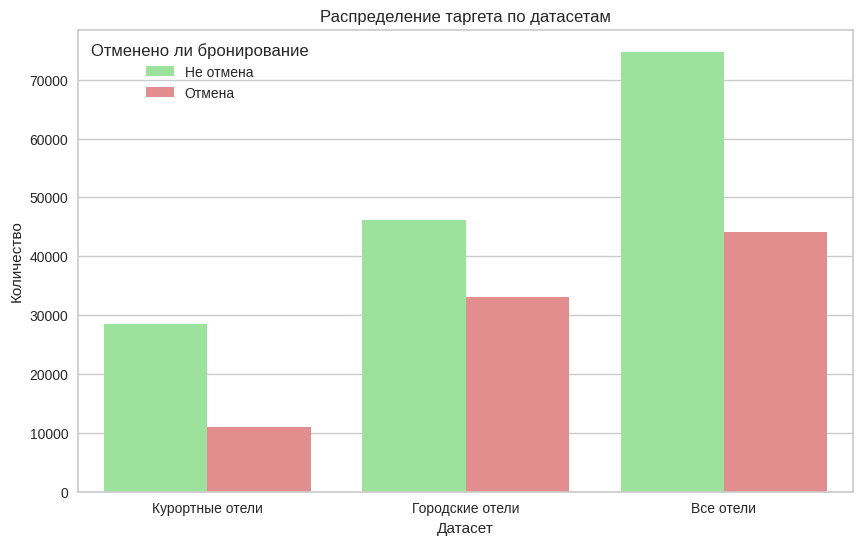

In [19]:
resort_subset['dataset'] = 'Курортные отели'
city_subset['dataset'] = 'Городские отели'
hotel_dataset['dataset'] = 'Все отели'
combined = pd.concat([resort_subset, city_subset, hotel_dataset])

plt.figure(figsize=(10, 6))
sns.countplot(data=combined, x='dataset', hue='is_canceled',
              palette={0: 'lightgreen', 1: 'lightcoral'})
plt.title('Распределение таргета по датасетам')
plt.xlabel('Датасет')
plt.ylabel('Количество')
plt.legend(title='Отменено ли бронирование', labels=['Не отмена', 'Отмена'])
plt.show()

Давайте еще посмотрим на распределение таргета по годам. Как мы позже узнаем, у нас есть не все данные за 2015 и 2017 год.

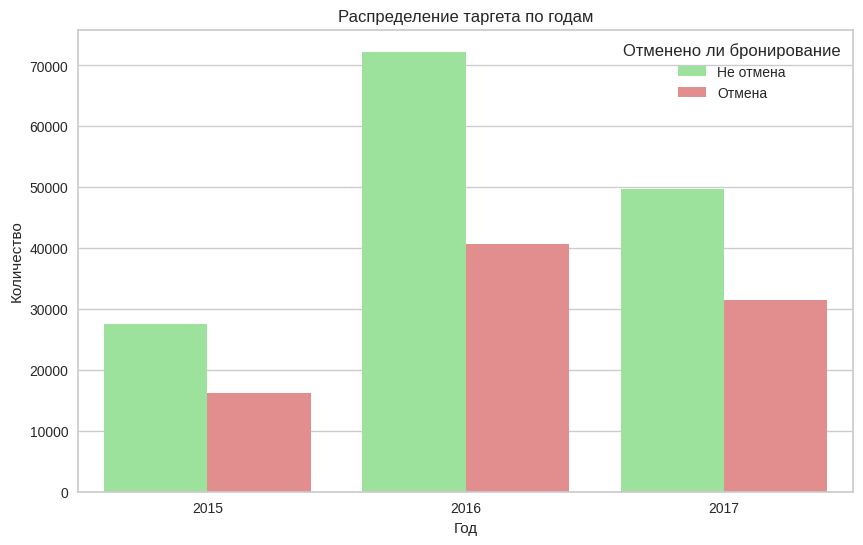

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined, x='arrival_date_year', hue='is_canceled',
              palette={0: 'lightgreen', 1: 'lightcoral'})
plt.title('Распределение таргета по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.legend(title='Отменено ли бронирование', labels=['Не отмена', 'Отмена'])
plt.show()

Как можно увидеть из графика, таргет не очень сбалансирован для всех трех датасетов. Тем не менее, было решено не брать идеально сбалансированные данные, поскольку это отображает распределение переменной в реальном мире: чаще всего брони подтверждают, а не отменяют.

In [21]:
# тут я изначально хотела сделать графики с линией по номерам недели для каждого года,
# но столкнулась со следующей ситуацией:
cancel_rate = hotel_dataset.groupby(['arrival_date_week_number', 'arrival_date_year'])['is_canceled'].mean().unstack('arrival_date_year')
cancel_rate

arrival_date_year,2015,2016,2017
arrival_date_week_number,,,
1,NaN,0.331858,0.339853
2,NaN,0.189873,0.389976
3,NaN,0.180365,0.296984
4,NaN,0.287744,0.379691
5,NaN,0.290553,0.321472
6,NaN,0.214706,0.296526
7,NaN,0.310710,0.339410
8,NaN,0.392495,0.332786
9,NaN,0.349142,0.339013


Изначально я планировала обучаться на 2015 и 2016 годах, а 2017 оставить на тест (out-of-time-approach), но я столкнулась с ситуацией, что у меня есть полные данные за 2016 год и нет данных за первую половину 2015 и вторую половину 2017. Учтем это и пока визуализируемся на данных только за 2016 год.

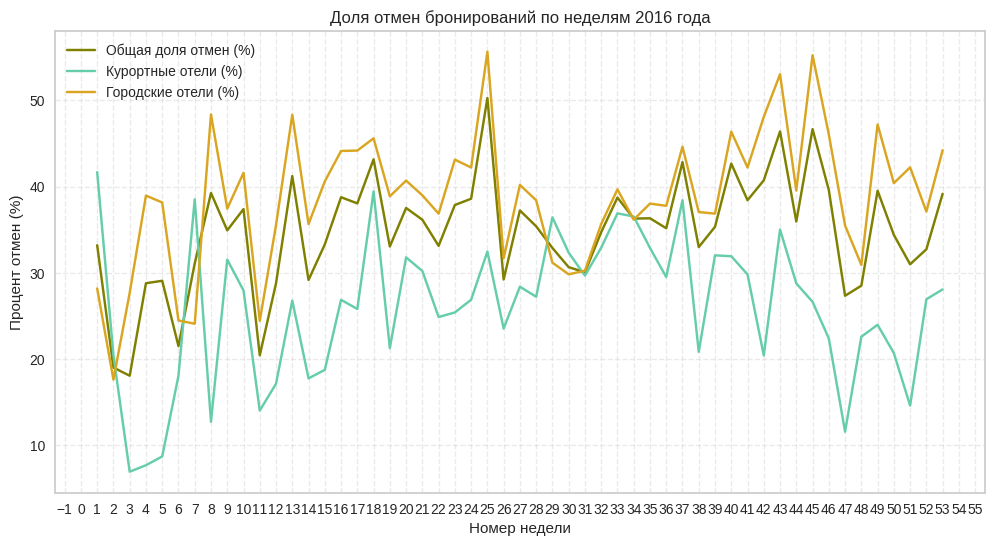

In [22]:
cancel_rate = hotel_dataset[hotel_dataset.arrival_date_year == 2016].groupby('arrival_date_week_number')['is_canceled'].mean() * 100
cancel_rate_rh = resort_subset[resort_subset.arrival_date_year == 2016].groupby('arrival_date_week_number')['is_canceled'].mean() * 100
cancel_rate_ch = city_subset[city_subset.arrival_date_year == 2016].groupby('arrival_date_week_number')['is_canceled'].mean() * 100


plt.figure(figsize=(12, 6))

cancel_rate.plot(color='olive', label='Общая доля отмен (%)')
cancel_rate_rh.plot(color='mediumaquamarine', label='Курортные отели (%)')
cancel_rate_ch.plot(color='goldenrod', label='Городские отели (%)')

plt.title('Доля отмен бронирований по неделям 2016 года')
plt.ylabel('Процент отмен (%)')
plt.xlabel('Номер недели')

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(fontsize=10, rotation=0)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()

Для всех трех типов отелей можно увидеть похожие паттерны: на ~25 неделе (июнь) происходит резкий рост числа отмен бронирований во всех трех типах отелей. Такая же ситуация наблюдается в 43-46 неделю месяца.

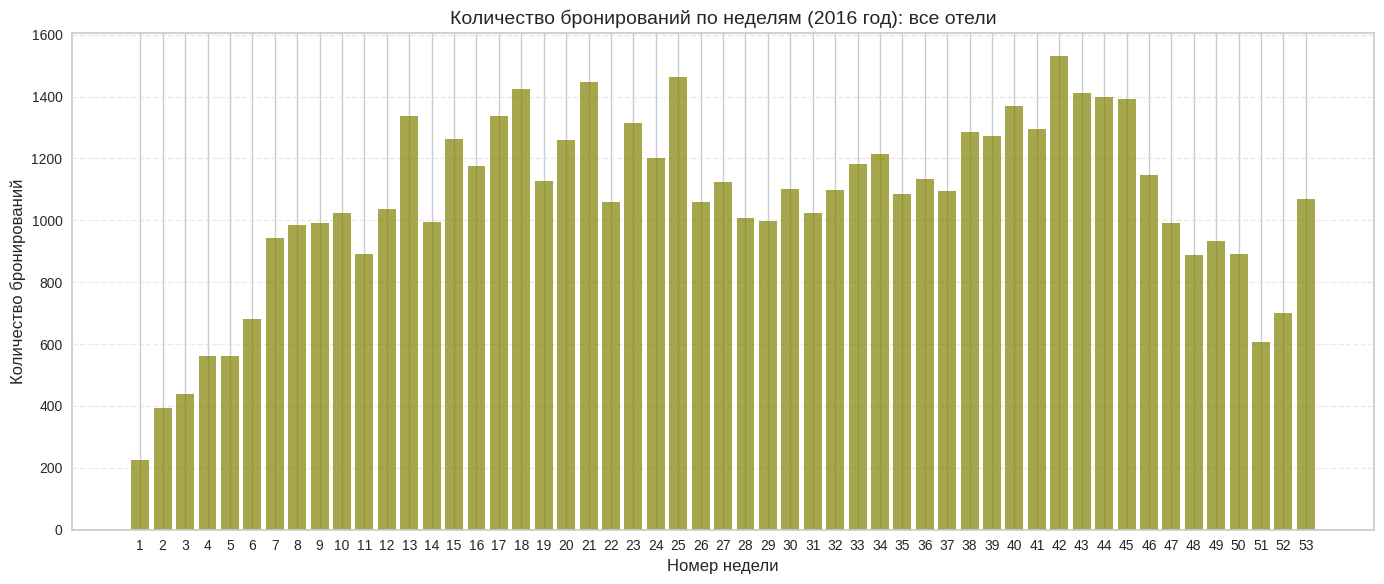

In [23]:
# кажется, временной слот у нас достаточно важен; давайте посмотрим на распределение данных в зависимости от недели
weekly_bookings = hotel_dataset[hotel_dataset['arrival_date_year'] == 2016].groupby('arrival_date_week_number').size()
weekly_bookings_rh = resort_subset[resort_subset['arrival_date_year'] == 2016].groupby('arrival_date_week_number').size()
weekly_bookings_ch = city_subset[city_subset['arrival_date_year'] == 2016].groupby('arrival_date_week_number').size()

plt.figure(figsize=(14, 6))

plt.bar(weekly_bookings.index, weekly_bookings, color='olive', alpha=0.7)

plt.title('Количество бронирований по неделям (2016 год): все отели', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.xticks(weekly_bookings.index, rotation=0, fontsize=10)  # Номера недель по оси X
plt.grid(axis='y', linestyle='--', alpha=0.4)  # Сетка только по оси Y
plt.tight_layout()
plt.show()

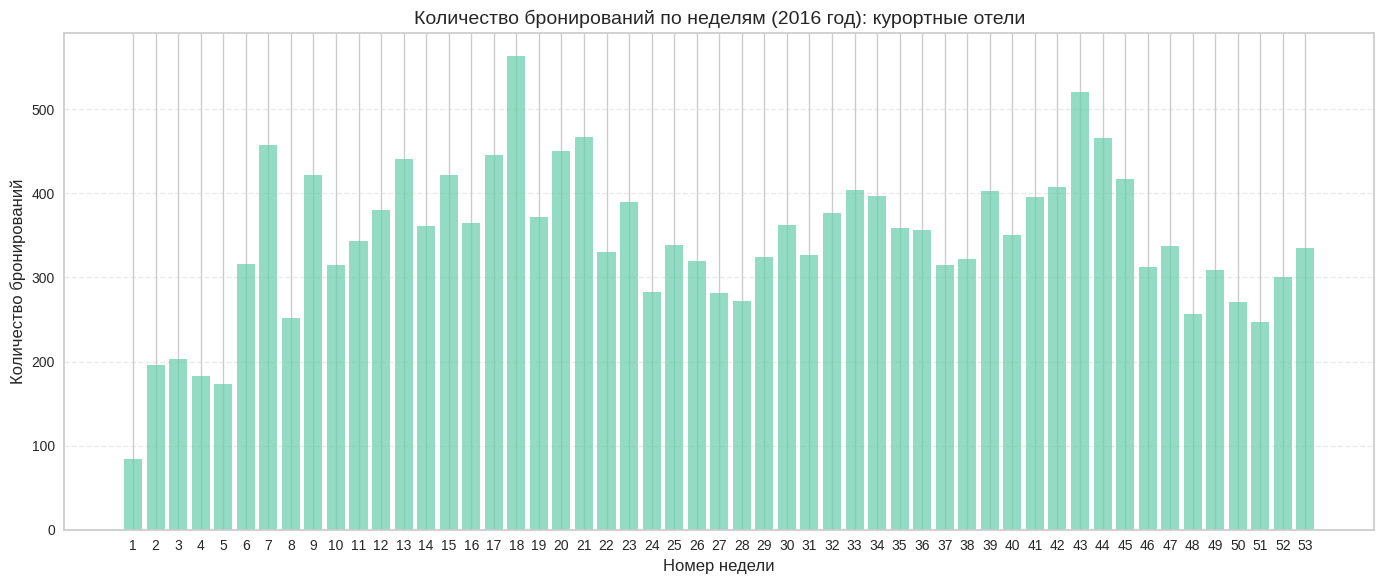

In [24]:
plt.figure(figsize=(14, 6))

plt.bar(weekly_bookings_rh.index, weekly_bookings_rh, color='mediumaquamarine', alpha=0.7)

plt.title('Количество бронирований по неделям (2016 год): курортные отели', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.xticks(weekly_bookings_rh.index, rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

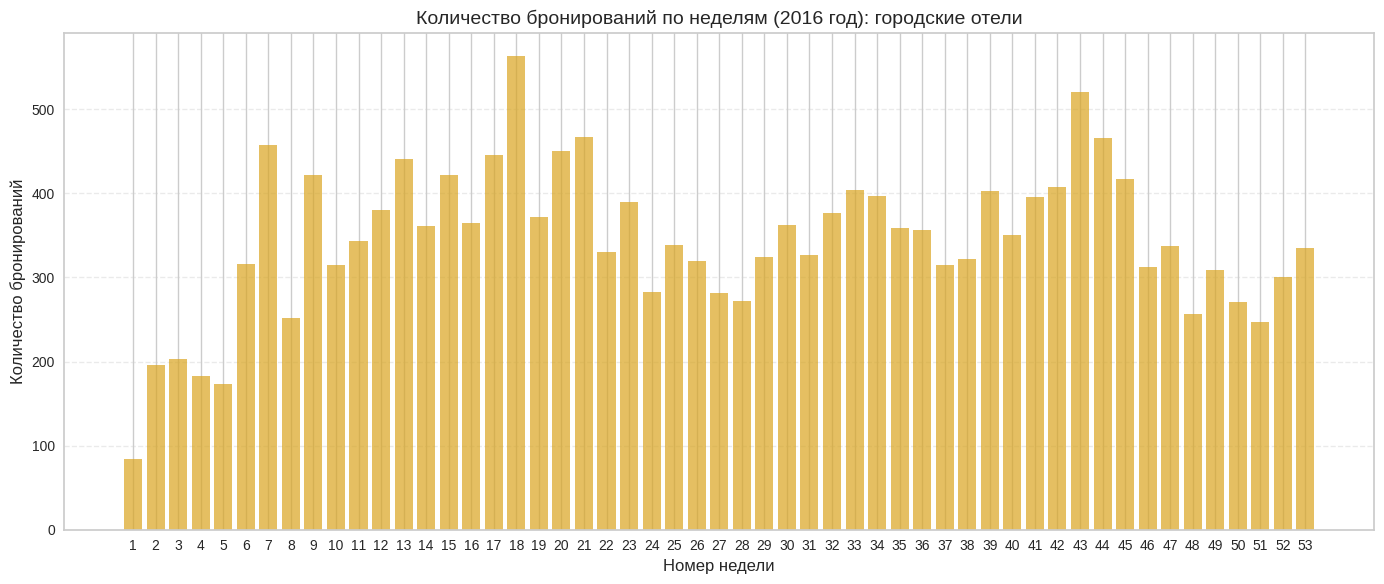

In [25]:
plt.figure(figsize=(14, 6))

plt.bar(weekly_bookings_rh.index, weekly_bookings_rh, color='goldenrod', alpha=0.7)

plt.title('Количество бронирований по неделям (2016 год): городские отели', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.xticks(weekly_bookings_rh.index, rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Как можно увидеть из трех графиков выше, распределение количества бронирований по месяцам по всем трем датасетам примерно одинаково.

In [26]:
# посмотрим на матрицы корреляции для числовых признаков; для этого выделим их
# в отдельную переменную

cat_features = [
    'is_repeated_guest',
    'hotel',
    'agent',
    'company',
    'country',
    'customer_type',
    'deposit_type',
    'distribution_channel',
    'meal',
    'market_segment',
    'reserved_room_type',
    'arrival_date_week_number']


to_drop = ['arrival_date_year', 'arrival_date_month',
           'arrival_date_day_of_month', 'date', 'dataset',
           'arrival_date_month_num']

numeric_features = hotel_dataset.columns.drop(to_drop + cat_features).tolist()

numeric_hd = hotel_dataset[numeric_features]

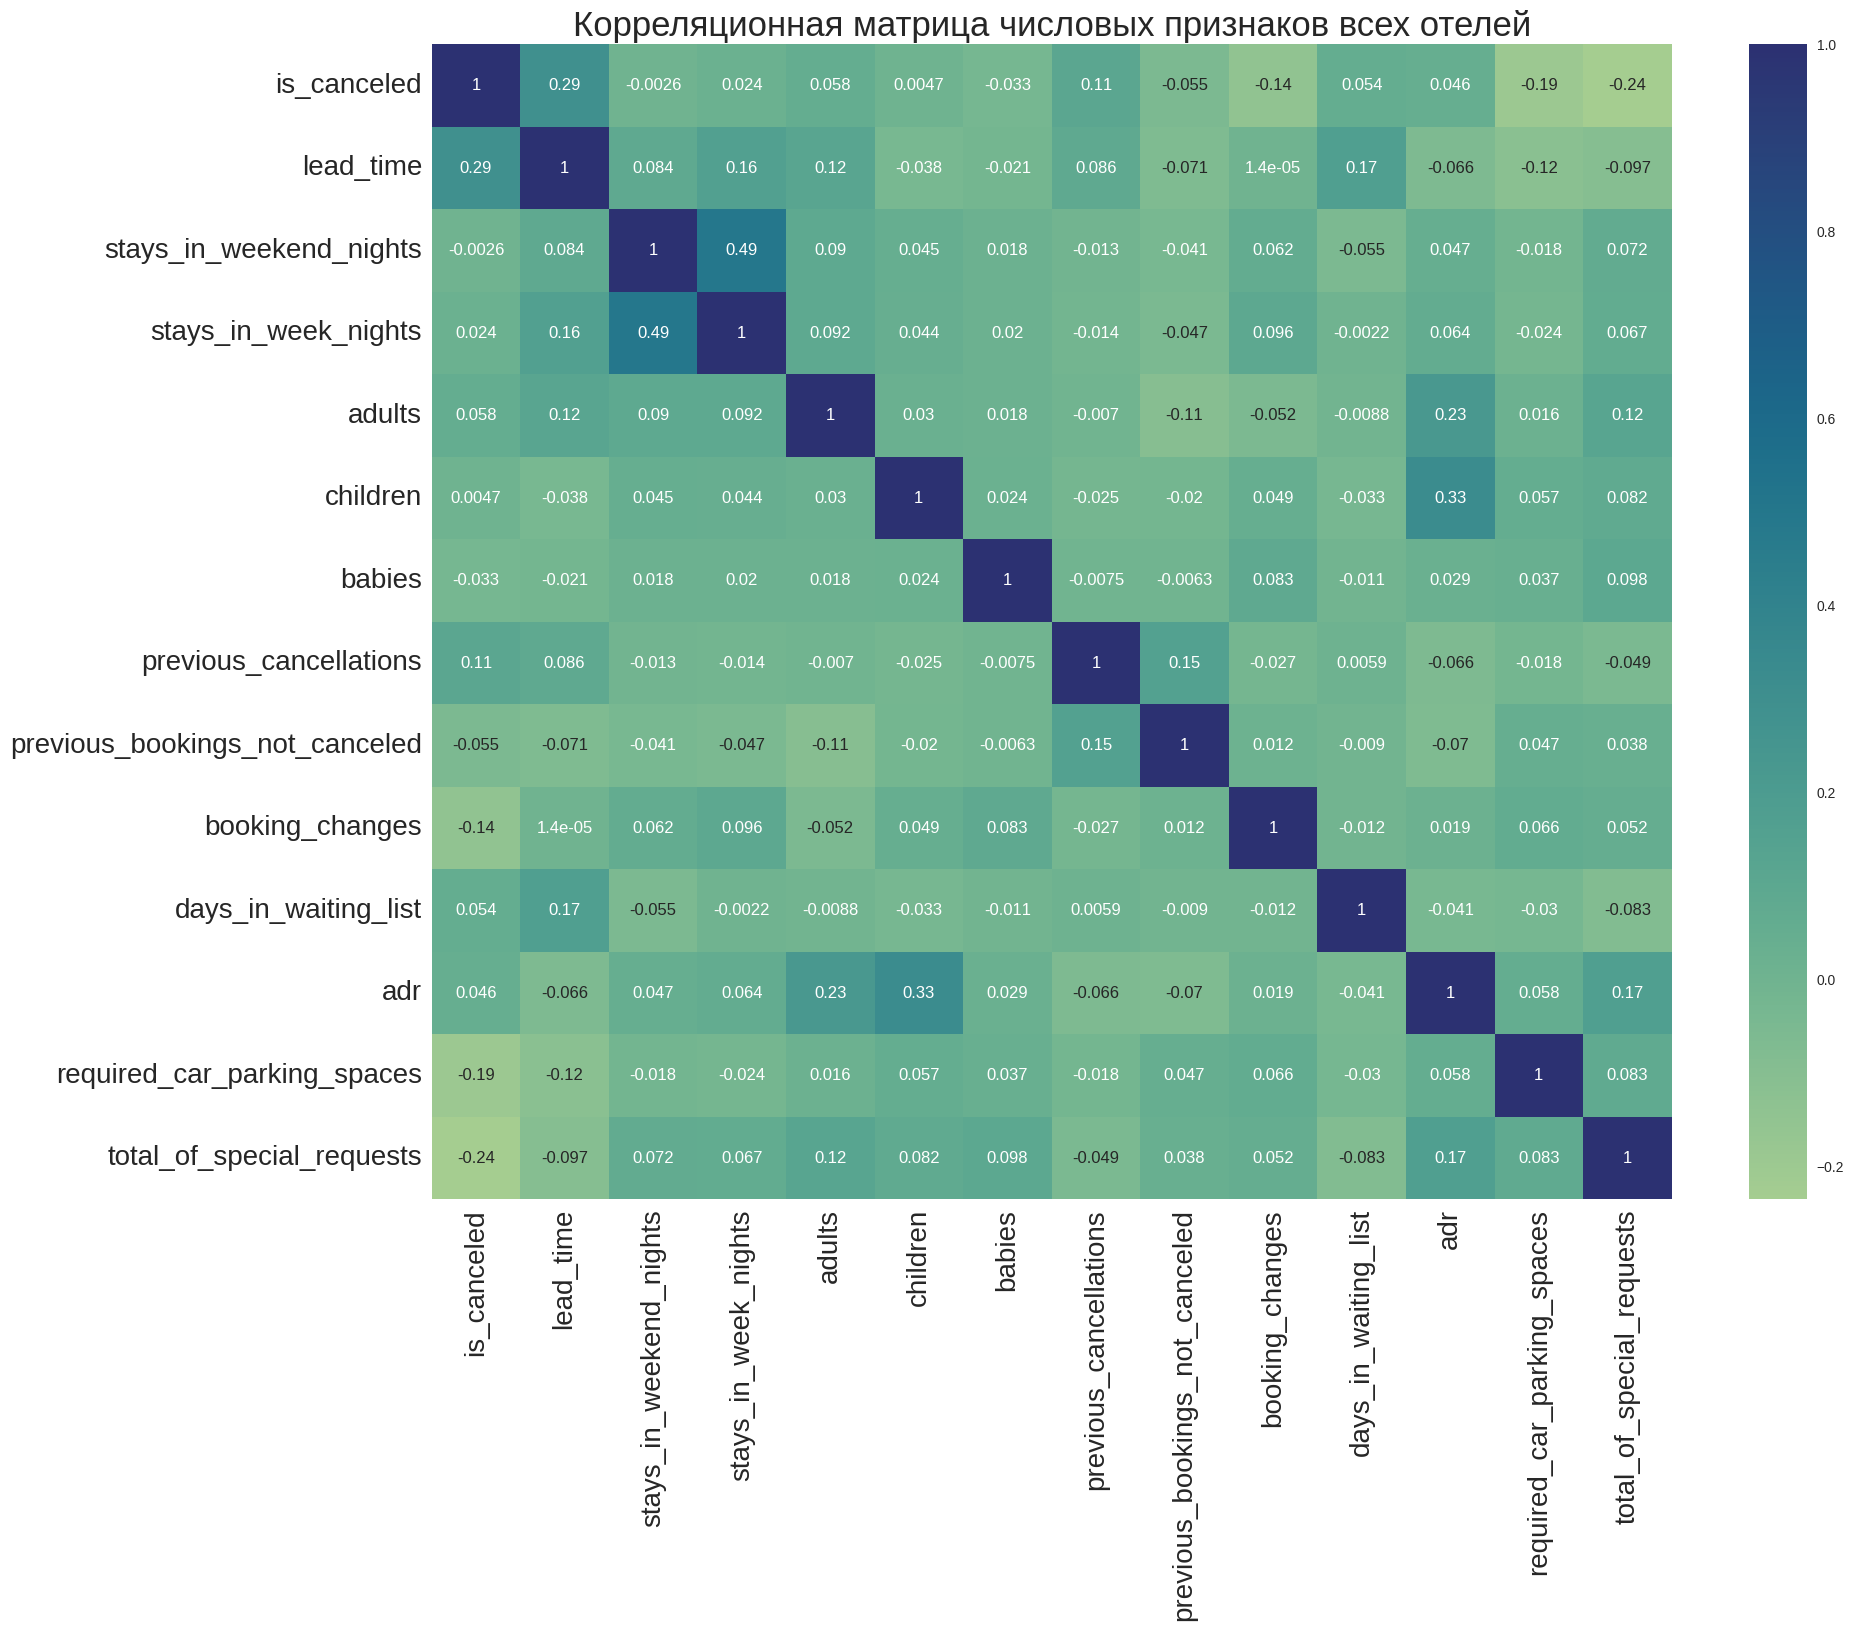

In [27]:
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(numeric_hd.corr(), annot=True,
            cmap='crest')
plt.title('Корреляционная матрица числовых признаков всех отелей', fontsize=25)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)
plt.show()

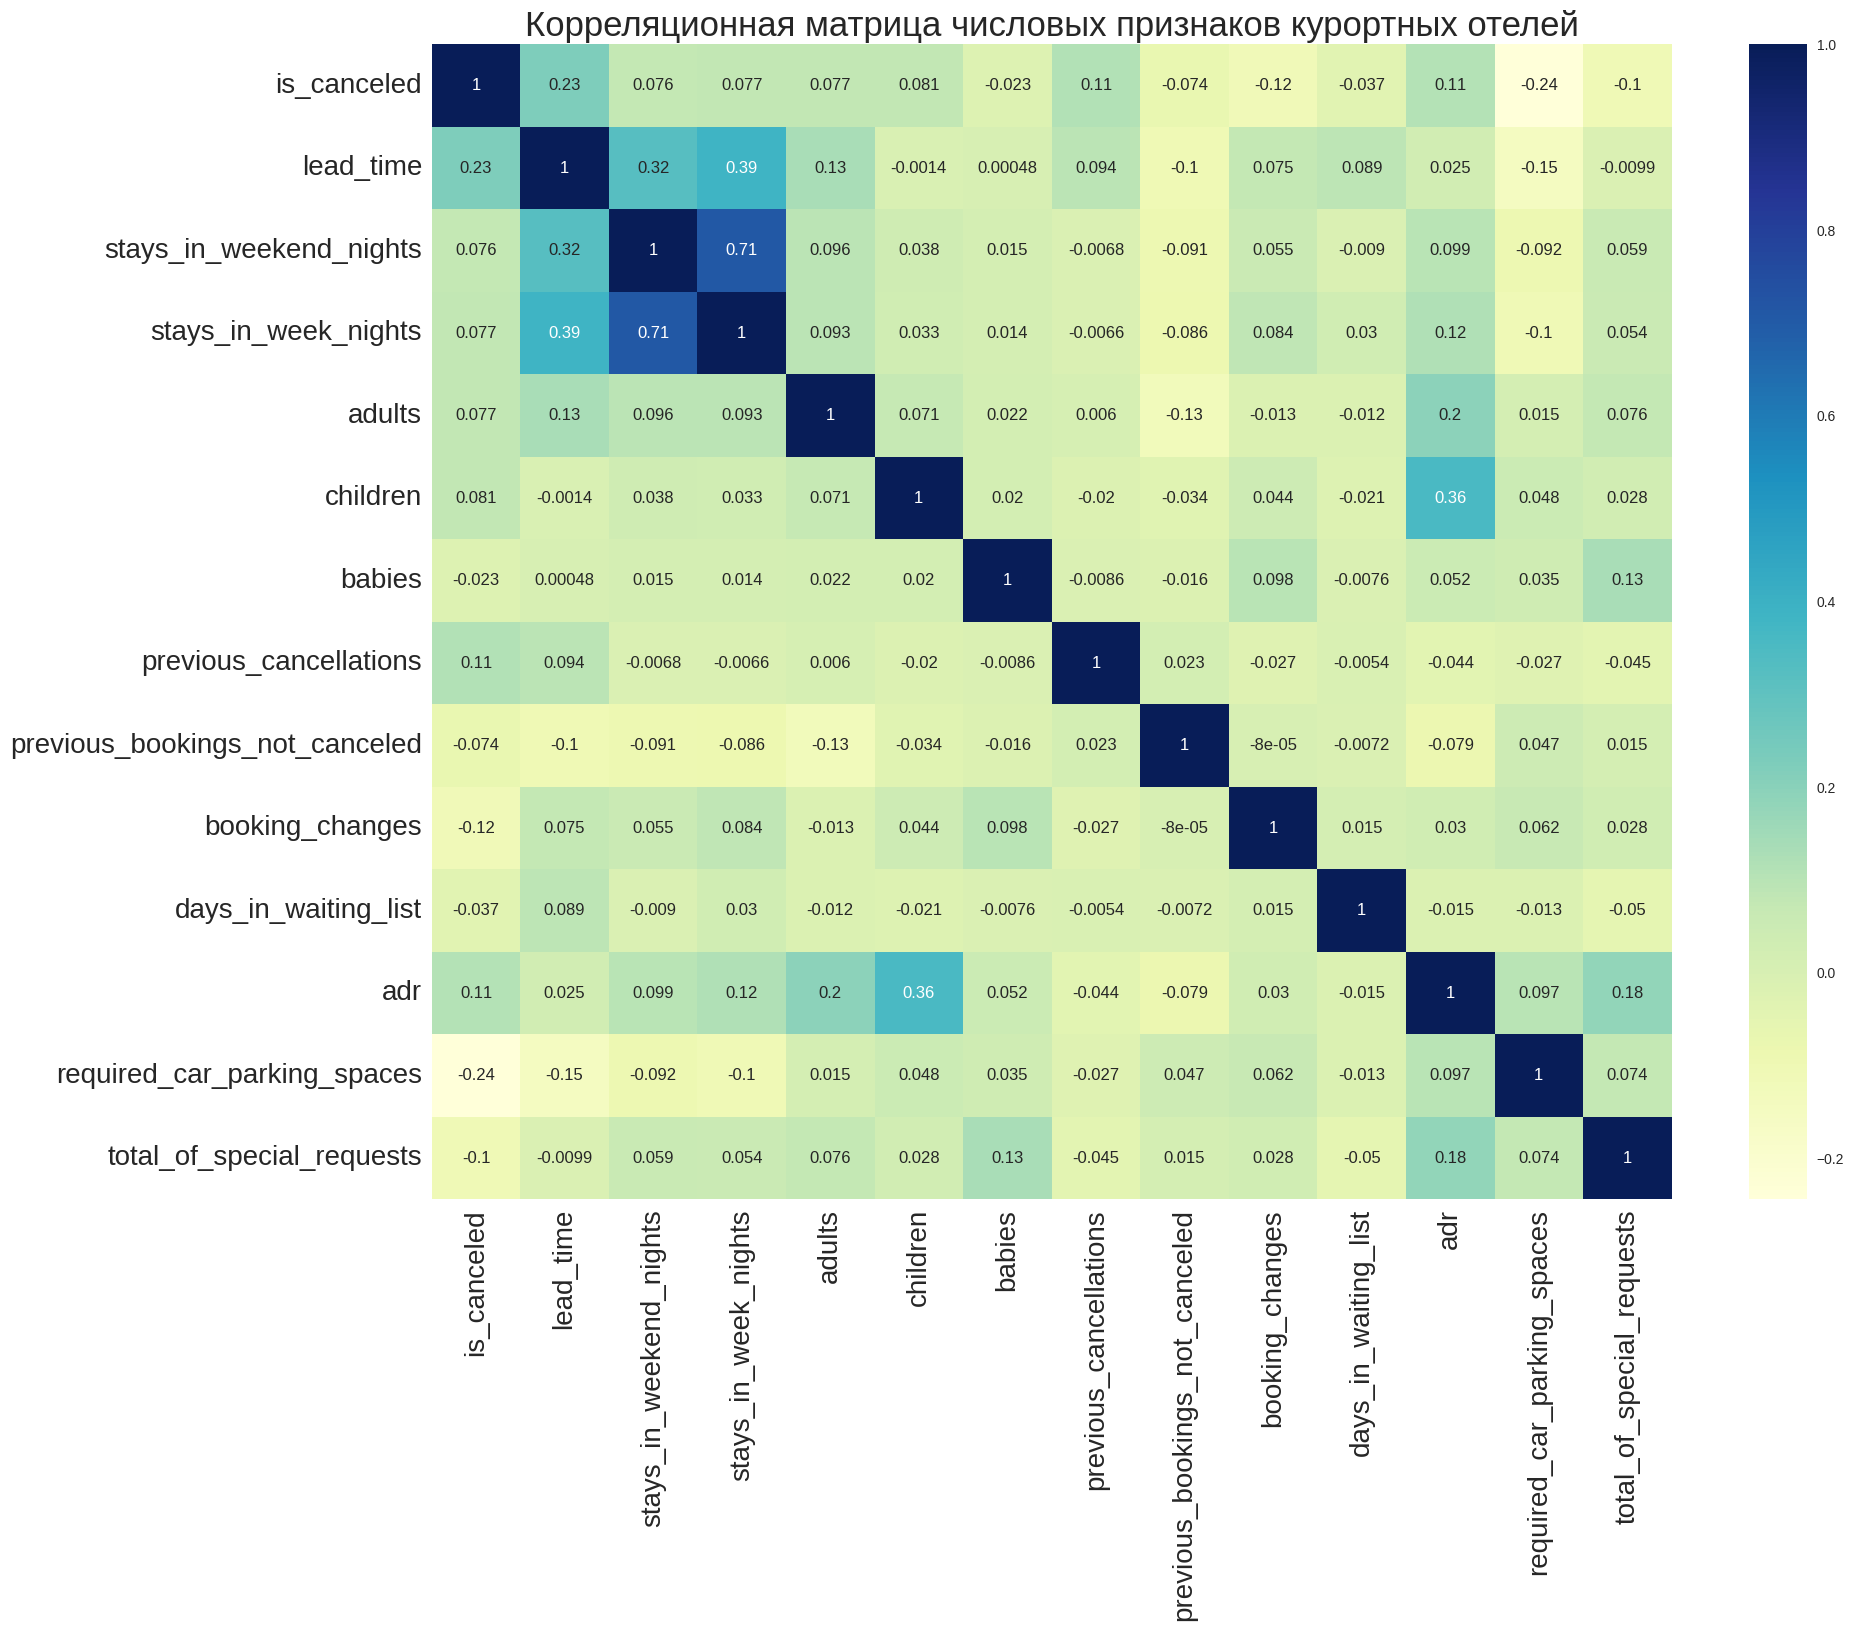

In [28]:
numeric_resort = resort_subset[numeric_features]
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(numeric_resort.corr(), annot=True,
                      cmap='YlGnBu')
plt.title('Корреляционная матрица числовых признаков курортных отелей', fontsize=25)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)
plt.show()

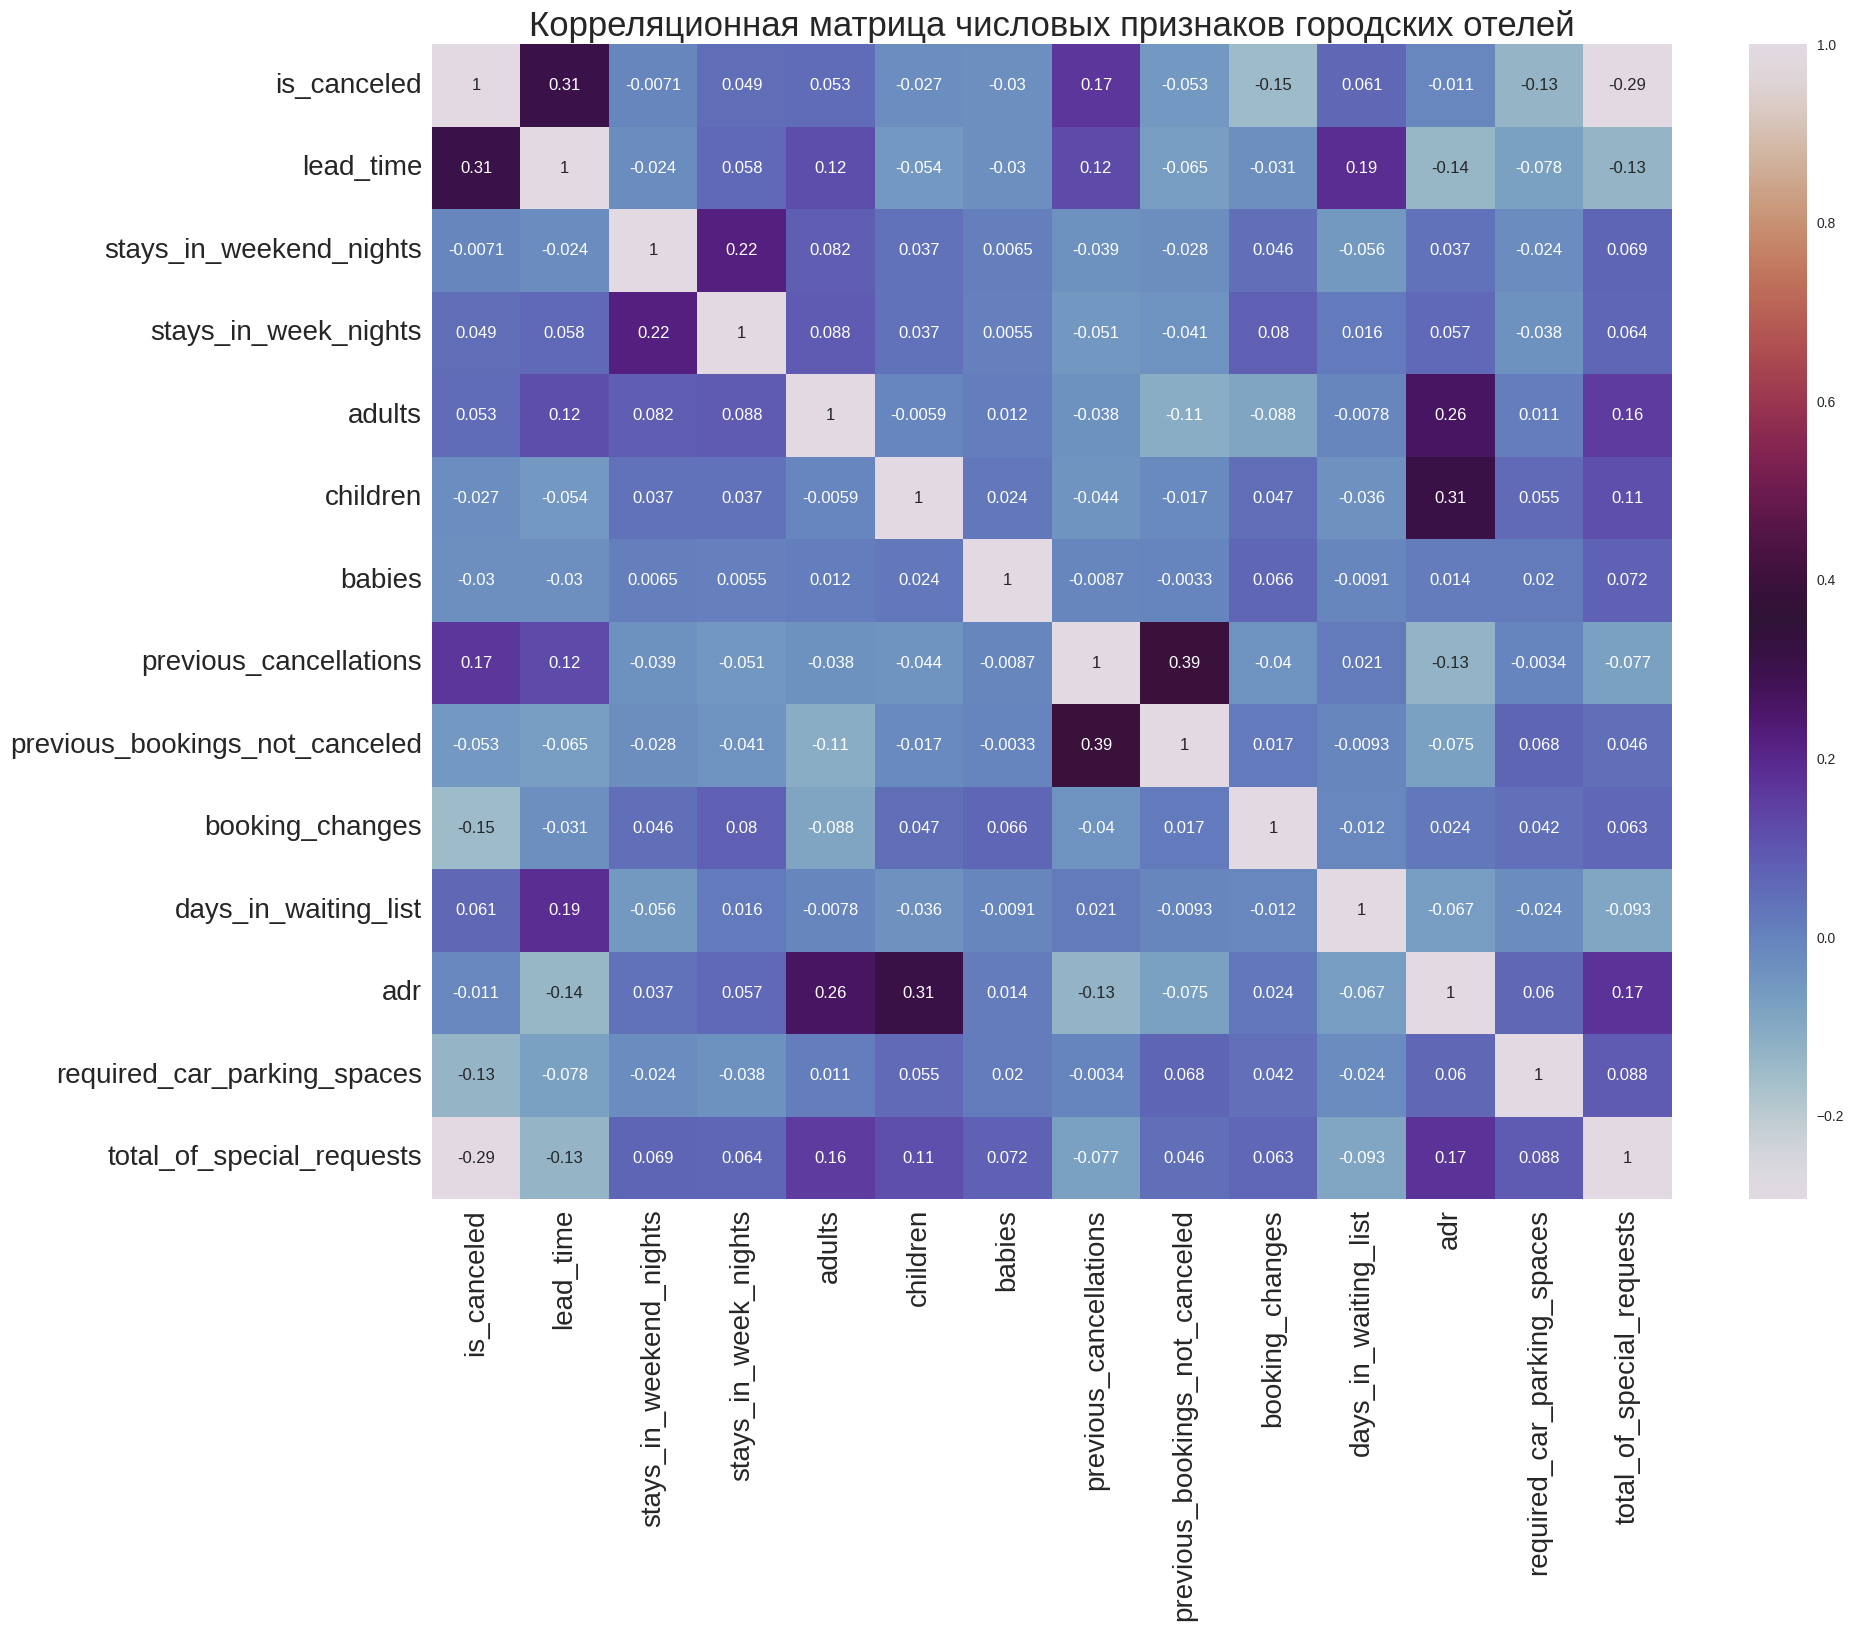

In [29]:
numeric_city = city_subset[numeric_features]
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(numeric_city.corr(), annot=True,
                      cmap='twilight')
plt.title('Корреляционная матрица числовых признаков городских отелей', fontsize=25)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)
plt.show()

## 1.3. Основные выводы по EDA, выбор методов и метрик для оценки качества

1. Поскольку таргетная переменная - бинарная, то разумно в качестве **бейзлайна** использовать **логистическую регрессию** для бинарной классификации.
2. Несколько отдельных выводов про корреляцию фичей для линейной регрессии:
 * сильных корреляций с таргетом не наблюдается
 * между фичами друг с другом заметно коррелируют `stays_in_weekend_nights` и `stays_in_week_nights` (особенно для курортных отелей) (коэффициент корреляции Пирсона 0.71, формула дана ниже)
 $$
 r_{XY} = \frac{\sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^n (Y_i - \bar{Y})^2}}
 $$
3. Изначально планировалось, что в качестве обучающей выборки будут выступать данные за 2015-2016 год ([out-of-time](https://habr.com/ru/companies/glowbyte/articles/524150/) подход), однако, как было показано выше, у нас нет полных данных за 2015 и 2017 год. Было решено прибегнуть к следующему делению, чтобы лучше смоделировать ситуацию, когда модель будет применяться в проде:
 * обучающая выборка: 27-53 недели за 2015 год, 1-35 недели за 2016 год;
 * тестовая выборка: 36-53 недели за 2016 год, 1-35 недели за 2017 год.

Данные за 27-35 недели есть за все 3 года. Было решено включить их в обучающую выборку, чтобы увеличить ее объем.
4. Как было показано выше, в данных есть достаточно **много категориальных переменных**, что наводит на вопросы о наличии линейной зависимости таргета с фичами. Скорее всего, результаты будут лучше при использовании **моделей бустинга**: во-первых, они умеют работать с категориальными значениями, во-вторых, для них не надо удалять имеющиеся у нас пропуски.

В качестве показателей качества базово будут использованы следующие метрики:
* Accuracy:
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$
* Precision:
$$
Precision = \frac{TP}{TP + FP}
$$
* Recall:
$$
Recall = \frac{TP}{TP + FN}
$$
* F1-score:
$$
F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}
$$
* AUC (Area Under the Curve, под кривой подразумевается ROC -  Receiver Operating Characteristic):
$$
AUC = \sum_{i=1}^{n-1} \frac{(FPR_{i+1} - FPR_i) \cdot (TPR_i + TPR_{i+1})}{2}
$$
$$
TPR = \frac{TP}{TP + FN}; FPR = \frac{FP}{TN + FP}
$$

# 2. Baseline: логистическая регрессия

## Логистическая регрессия в формулах

* линейная комбинация признаков
$$
z = w_0 + w_1 x_1 + \dots + w_n x_n = \mathbf{w}^T \mathbf{x}
$$

* логит-преобразование и получение вероятности
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

$$
\hat{y} = \begin{cases}
1, & \text{если } \sigma(z) \geq 0.5, \\
0, & \text{иначе}.
\end{cases}
$$

* функция потерь: кросс-энтропия (оценка разницы между двумя распределениями вероятности)
$$
\mathcal{L}(\mathbf{w}) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\sigma(z_i)) + (1 - y_i) \log(1 - \sigma(z_i)) \right]
$$
* оптимизация: градиентный спуск (задача - минимизировать функцию потерь)
$$
\frac{\partial \mathcal{L}}{\partial w_j} = \frac{1}{N} \sum_{i=1}^N (\sigma(z_i) - y_i) x_{i,j}
$$
* обновление весов; α - размер шага
$$
w_j := w_j - \alpha \frac{\partial \mathcal{L}}{\partial w_j}
$$

## Деление на train-test + Feature-engineering: One-hot encoding

Сначала мы обучаем линейную модель. Для этого нам надо подать туда категориальные переменные в виде чисел, для чего подходит one-hot encoding. Также впишем сюда же one-hot encoding.

In [30]:
def preprocess_and_split(dataset, target='is_canceled',
                         weeks_2016_train=range(1, 36),
                         weeks_2016_test=range(36, 54),
                         to_drop=None,
                         cat_features=None,
                         numeric_features=None,
                         hotel_remove=False):

    dataset = dataset.copy()

    train_set = dataset[(dataset.arrival_date_year == 2015) | \
     ((dataset.arrival_date_year == 2016) & \
      dataset.arrival_date_week_number.isin(weeks_2016_train))].copy()

    test_set = dataset[((dataset.arrival_date_year == 2016) & \
                        dataset.arrival_date_week_number.isin(weeks_2016_test)) | \
                         (dataset.arrival_date_year == 2017)].copy()


    y_train = train_set[target].copy()
    y_test = test_set[target].copy()

    if to_drop is None:
        to_drop = []

    columns_to_drop = list(set(to_drop + [target]))
    columns_to_drop = [col for col in columns_to_drop if col in train_set.columns]

    train_features = train_set.drop(columns=columns_to_drop, errors='ignore')
    test_features = test_set.drop(columns=columns_to_drop, errors='ignore')

    if cat_features is None:
        cat_features = []

    if numeric_features is None:
        numeric_features = []

    if hotel_remove and 'hotel' in cat_features:
        cat_features.remove('hotel')

    cat_features = [col for col in cat_features if col in train_features.columns]
    numeric_features = [col for col in numeric_features if col in train_features.columns]

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    if cat_features:
        encoder.fit(train_features[cat_features])
        train_encoded = encoder.transform(train_features[cat_features])
        test_encoded = encoder.transform(test_features[cat_features])

        train_encoded_df = pd.DataFrame(train_encoded,
                                        columns=encoder.get_feature_names_out(cat_features),
                                        index=train_features.index)

        test_encoded_df = pd.DataFrame(test_encoded,
                                       columns=encoder.get_feature_names_out(cat_features),
                                       index=test_features.index)

        X_train = pd.concat([train_features[numeric_features],
                             train_encoded_df], axis=1)

        X_test = pd.concat([test_features[numeric_features],
                            test_encoded_df], axis=1)
    else:
        X_train = train_features[numeric_features].copy()
        X_test = test_features[numeric_features].copy()

    return X_train, y_train, X_test, y_test

# проверим размеры обучающей и тестовой выборки
def check_shape(X_train, y_train, X_test, y_test, label=None):

    print(label)

    print('Размеры обучающей выборки: ', X_train.shape)
    if len(X_train) != len(y_train):
        print('Размеры таргета и фичей не совпадают')

    print('Размеры тестовой выборки: ', X_test.shape)
    if len(X_test) != len(y_test):
        print('Размеры таргета и фичей не совпадают')
    print('\n')

In [31]:
X_train_hd, y_train_hd, X_test_hd, y_test_hd = preprocess_and_split(hotel_dataset,
                                                                    target='is_canceled',
                                                                    to_drop=to_drop,
                                                                    cat_features=cat_features,
                                                                    numeric_features=numeric_features)

X_train_resort, y_train_resort, X_test_resort, y_test_resort = preprocess_and_split(resort_subset,
                                                                    target='is_canceled',
                                                                    to_drop=to_drop,
                                                                    cat_features=cat_features,
                                                                    numeric_features=numeric_features,
                                                                    hotel_remove=True)

X_train_city, y_train_city, X_test_city, y_test_city = preprocess_and_split(city_subset,
                                                                    target='is_canceled',
                                                                    to_drop=to_drop,
                                                                    cat_features=cat_features,
                                                                    numeric_features=numeric_features,
                                                                    hotel_remove=True)

check_shape(X_train_hd, y_train_hd, X_test_hd, y_test_hd,
            label='Данные по всем отелям')
check_shape(X_train_resort, y_train_resort, X_test_resort, y_test_resort,
            label='Данные по курортным отелям')
check_shape(X_train_city, y_train_city, X_test_city, y_test_city,
            label='Данные по городским отелям')

Данные по всем отелям
Размеры обучающей выборки:  (57890, 716)
Размеры тестовой выборки:  (61012, 716)


Данные по курортным отелям
Размеры обучающей выборки:  (20172, 487)
Размеры тестовой выборки:  (19424, 487)


Данные по городским отелям
Размеры обучающей выборки:  (37718, 483)
Размеры тестовой выборки:  (41588, 483)




## Логистическая регрессия без кросс-валидации

### Все отели

#### threshold=0.5

In [32]:
# пайплайн + скалирование
logreg_baseline_hd = make_pipeline(StandardScaler(),
                                   LogisticRegression(class_weight='balanced',
                                                      max_iter=1000))
logreg_baseline_hd.fit(X_train_hd, y_train_hd)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [33]:
y_preds_hd = logreg_baseline_hd.predict(X_test_hd)
print(classification_report(y_test_hd, y_preds_hd))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     37538
           1       0.77      0.65      0.71     23474

    accuracy                           0.79     61012
   macro avg       0.79      0.76      0.77     61012
weighted avg       0.79      0.79      0.79     61012



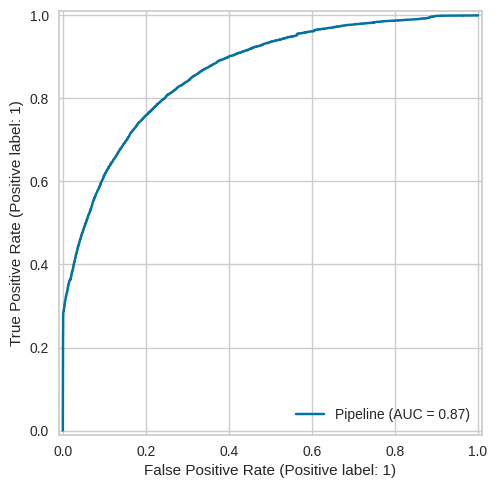

In [34]:
RocCurveDisplay.from_estimator(logreg_baseline_hd, X_test_hd, y_test_hd)

#### threshold через оптимизацию ROC-AUC

В наших данных, как было замечено ранее, есть дисбаланс в таргетной переменной. Кроме того, иногда нам важно минимизировать конкретные типы ошибок (например, балансировать между FN/FP). Для этой цели стоит подбирать порог, при котором мы относим объект к тому или иному классу. В [статье](https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/) описано два подхода:
* оптимизация через ROC-AUC
* оптимизация через Accuracy

Последний пункт подходит для сбалансированных данных. Давайте применим ROC-AUC подход с учетом существующего дисбаланса классов.

In [35]:
def optimize_threshold(X_train, y_train, X_test, y_test, model):
    fpr, tpr, thresholds = roc_curve(
    y_true=y_train,
    y_score=model.predict_proba(X_train)[:, 1],
    drop_intermediate=False)

    plt.scatter(thresholds,np.abs(fpr+tpr-1))
    plt.xlabel("Threshold")
    plt.ylabel("|FPR + TPR - 1|")
    plt.show()

    thres = thresholds[np.argmin(np.abs(fpr+tpr-1))]
    probas = model.predict_proba(X_test)[:,1]
    y_preds_thres = (probas >= thres).astype(int)
    print(classification_report(y_test, y_preds_thres))

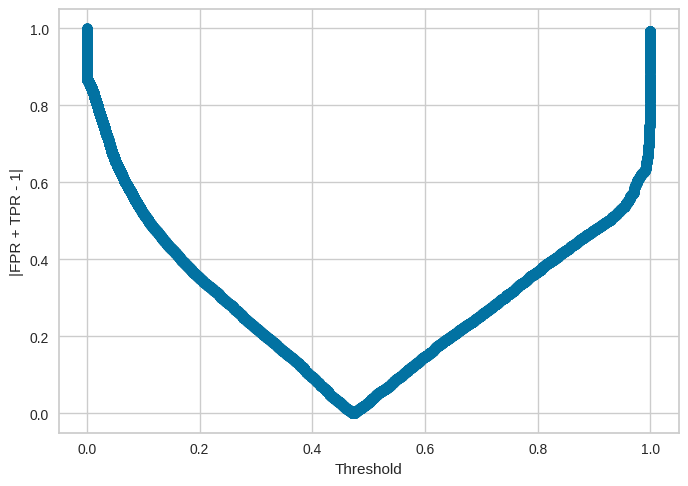

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     37538
           1       0.76      0.67      0.71     23474

    accuracy                           0.79     61012
   macro avg       0.78      0.77      0.77     61012
weighted avg       0.79      0.79      0.79     61012



In [36]:
optimize_threshold(X_train_hd, y_train_hd, X_test_hd, y_test_hd,
                   logreg_baseline_hd)

Мы стали чуть лучше предсказывать непосредственно отмены.

#### Визуализация важности признаков

In [37]:
# так как признаков у нас несколько сотен, визуализировать все не получится, достанем топ
def get_top_n_features(pipeline_trained, n):
    model = pipeline_trained.named_steps['logisticregression']

    viz = FeatureImportances(model, relative=False, stack=False, topn=n)
    viz.fit(X_train_hd, y_train_hd)

    # тут мы достаем топ по модулю
    coef = model.coef_[0]
    top_indices = np.argsort(np.abs(coef))[::-1][:n]

    viz.features_ = np.array(X_train_hd.columns)[top_indices]
    viz.importances_ = coef[top_indices]
    viz.show()

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


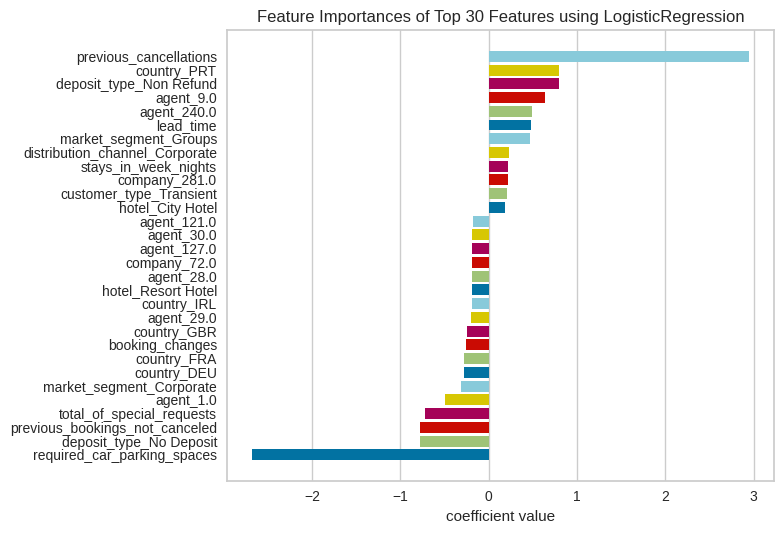

In [38]:
get_top_n_features(logreg_baseline_hd, 30)

Как можно увидеть, наиболее важные признаки дляи логистической регрессии оказались числовые, что логично, учитывая ее линейную природу.

### Курортные отели

#### threshold=0.5

In [39]:
# пайплайн + скалирование
logreg_baseline_resort = make_pipeline(StandardScaler(),
                                       LogisticRegression(class_weight='balanced',
                                                          max_iter=1000))
logreg_baseline_resort.fit(X_train_resort, y_train_resort)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [40]:
y_preds = logreg_baseline_resort.predict(X_test_resort)
print(classification_report(y_test_resort, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     13707
           1       0.68      0.59      0.63      5717

    accuracy                           0.80     19424
   macro avg       0.76      0.74      0.75     19424
weighted avg       0.79      0.80      0.79     19424



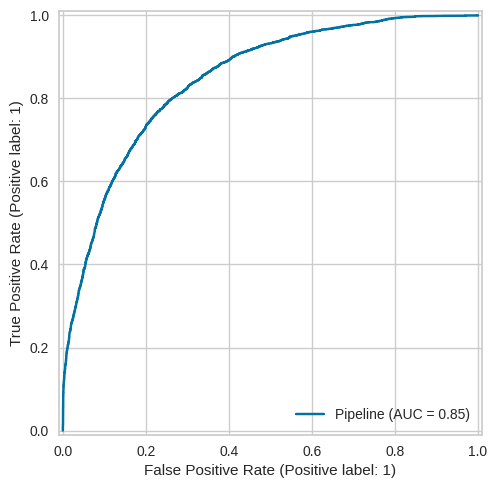

In [41]:
RocCurveDisplay.from_estimator(logreg_baseline_resort, X_test_resort,
                               y_test_resort)

#### threshold через оптимизацию ROC-AUC


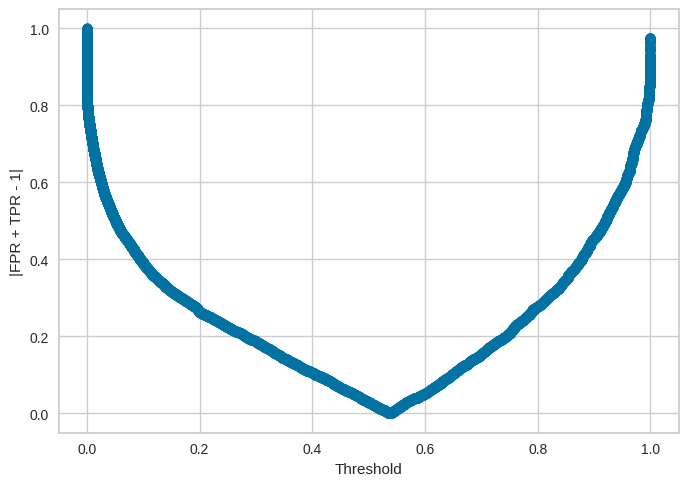

              precision    recall  f1-score   support

           0       0.83      0.90      0.86     13707
           1       0.70      0.57      0.62      5717

    accuracy                           0.80     19424
   macro avg       0.76      0.73      0.74     19424
weighted avg       0.79      0.80      0.79     19424



In [42]:
optimize_threshold(X_train_resort, y_train_resort, X_test_resort, y_test_resort,
                   logreg_baseline_resort)

Опять же, лучше стали предсказывать отмены, но у нас упал precision.

#### Визуализация важности признаков

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


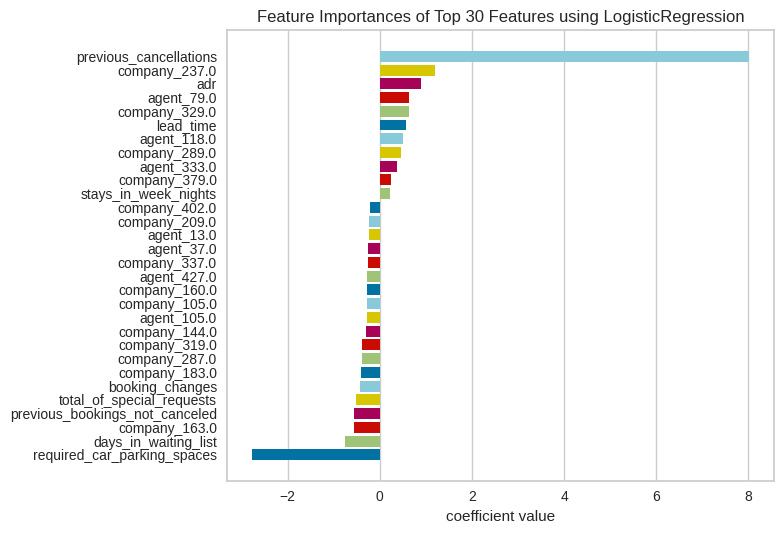

In [43]:
get_top_n_features(logreg_baseline_resort, 30)

### Городские отели

#### threshold=0.5

In [44]:
logreg_baseline_city = make_pipeline(StandardScaler(),
                                     LogisticRegression(class_weight='balanced',
                                                          max_iter=1000))
logreg_baseline_city.fit(X_train_city, y_train_city)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [45]:
y_preds = logreg_baseline_city.predict(X_test_city)
print(classification_report(y_test_city, y_preds))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82     23831
           1       0.79      0.64      0.71     17757

    accuracy                           0.78     41588
   macro avg       0.78      0.76      0.76     41588
weighted avg       0.78      0.78      0.77     41588



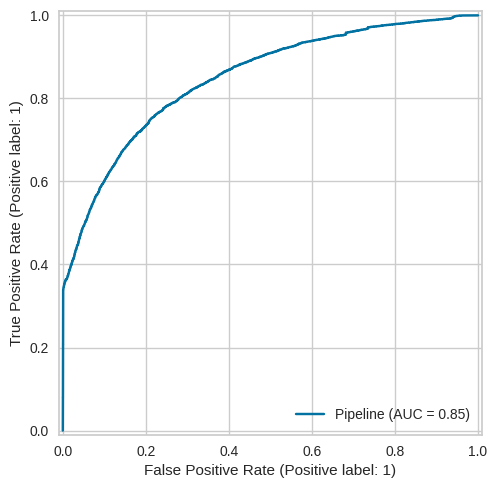

In [46]:
RocCurveDisplay.from_estimator(logreg_baseline_city, X_test_city, y_test_city)

#### threshold через оптимизацию ROC-AUC

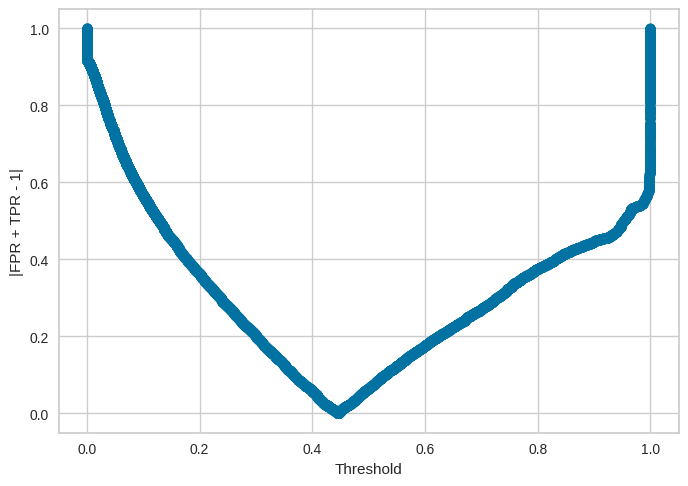

              precision    recall  f1-score   support

           0       0.78      0.85      0.81     23831
           1       0.77      0.68      0.72     17757

    accuracy                           0.78     41588
   macro avg       0.78      0.77      0.77     41588
weighted avg       0.78      0.78      0.78     41588



In [47]:
optimize_threshold(X_train_city, y_train_city, X_test_city, y_test_city,
                   logreg_baseline_city)

#### Визуализация важности признаков

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


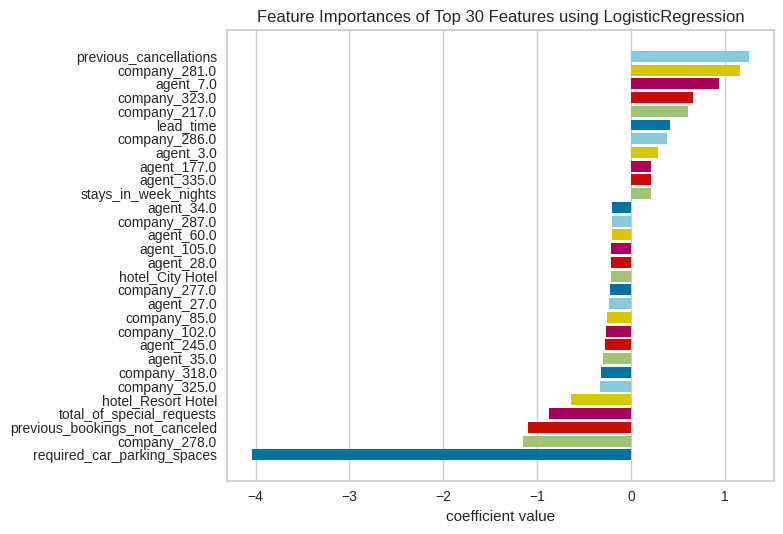

In [48]:
get_top_n_features(logreg_baseline_city, 30)

А тут на первое место вышла уже компания!

К слову, для всех трех групп важным оказался признак "количество предыдущих отмен", что достаточно логично: если гость отменял до этого штуки, то отменит и дальше.

А вот большое значение количества забронированных машин (если много забронировали, то скорее всего не отменят бронь) говорит о том, что гость серьезно планирует поездку. Он молодец.

# Логистическая регрессия: подбор гиперпараметров

Чтобы улучшить бейзлайн, попробуем провести кросс-валидацию для гиперпараметров логистической регрессии. Для кросс-валидации используем фреймворк [optuna](https://habr.com/ru/companies/skillfactory/articles/900658/): он делает подбор гиперпараметров не настолько долго, как `GridSearchCV`, при этом умнее, чем `RandomSearchCV`. Он подбирает гиперпараметры, основываясь на [TPE](https://arxiv.org/pdf/1208.3719). Механика этого устроена следующим образом (тут небольшой пересказ [главы из учебника ШАДа](https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov)):
1. Сначала мы "разогреваем" модель, подбирая значения гиперпараметров и считая качество модели
2. Затем мы выбираем "хорошие" и "плохие" значения гиперпараметров и строим по ним оценки распределения: пусть l(x) - лучшие результаты, g(x) - худшие.
3. Далее высчитывается Expected Improvement (EI), на основе значения которой ищется "новая точка" для гиперпараметра. Наша задача - максимизировать попадание точки в распределение l(x) и минимизировать вероятность попадания в распределение g(x).
$$
EI(x) = \frac{l(x)}{g(x)}
$$
4. С каждой новой итерацией мы обновляем значения распределений и ищем значения гиперпараметра заново.

У нас во всех случаях не то что сильно высокая accuracy. Давайте попробуем ее максимизировать. Подбирать будем в первую очередь силу регуляризации:
* `C`: сила регуляризации (для избежания переобучения) (дефолт - **`1.0`**)

In [49]:
def optuna_cv(X, y, n_trials=25):

    def objective(trial):
        logreg_c = trial.suggest_float("logreg_c", 1e-5, 1e2, log=True)

        model = LogisticRegression(C=logreg_c, max_iter=1000,
                                   class_weight='balanced')

        score = cross_val_score(model, X, y, n_jobs=-1, cv=3)
        accuracy = score.mean()

        return accuracy


    study = optuna.create_study(direction="maximize")

    study.optimize(objective, n_trials=n_trials)

    return study

## Все отели

In [64]:
# params_cv_hd = optuna_cv(X_train_hd, y_train_hd)

[I 2025-06-16 17:44:25,971] A new study created in memory with name: no-name-abe6c96b-035e-4f96-9a8a-adef7f030378
[I 2025-06-16 17:44:48,049] Trial 0 finished with value: 0.6616685534686865 and parameters: {'logreg_c': 3.353264030076181e-05}. Best is trial 0 with value: 0.6616685534686865.
[I 2025-06-16 17:47:10,114] Trial 1 finished with value: 0.6836066544669799 and parameters: {'logreg_c': 2.9227060056091383}. Best is trial 1 with value: 0.6836066544669799.
[I 2025-06-16 17:49:26,559] Trial 2 finished with value: 0.6814990989027158 and parameters: {'logreg_c': 2.042960637982261}. Best is trial 1 with value: 0.6836066544669799.
[I 2025-06-16 17:50:58,444] Trial 3 finished with value: 0.7190185215908561 and parameters: {'logreg_c': 0.0016996172432908589}. Best is trial 3 with value: 0.7190185215908561.
[I 2025-06-16 17:53:14,798] Trial 4 finished with value: 0.7070821336893406 and parameters: {'logreg_c': 0.007226246053288739}. Best is trial 3 with value: 0.7190185215908561.
[I 2025-0

In [65]:
# save_bnr(params_cv_hd, 'binary_files/optuna_cv_hd_logreg.pkl')

In [66]:
params_cv_hd = load_bnr("binary_files/optuna_cv_hd_logreg.pkl")

In [67]:
logreg_cv_hd = make_pipeline(StandardScaler(),
                                       LogisticRegression(C=params_cv_hd.best_params['logreg_c'],
                                                          max_iter=1000,
                                                          class_weight='balanced'))
logreg_cv_hd.fit(X_train_hd, y_train_hd)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0011157793046422805,
                                    class_weight='balanced', max_iter=1000))])

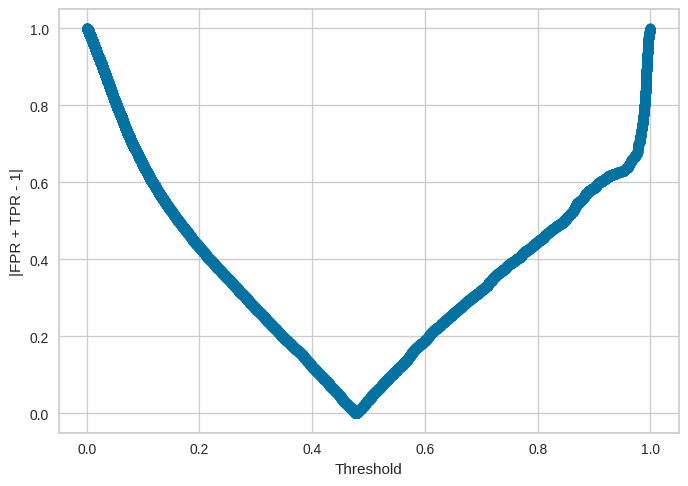

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     37538
           1       0.76      0.68      0.72     23474

    accuracy                           0.79     61012
   macro avg       0.79      0.77      0.78     61012
weighted avg       0.79      0.79      0.79     61012



In [68]:
optimize_threshold(X_train_hd, y_train_hd, X_test_hd, y_test_hd,
                   logreg_cv_hd)

Немного (буквально на 1%) выросла метрика

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


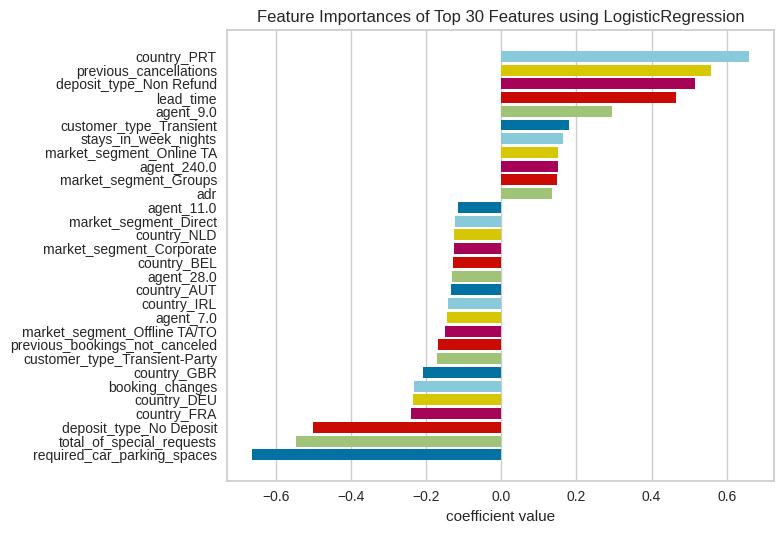

In [77]:
get_top_n_features(logreg_cv_hd, 30)

## Курортные отели

In [69]:
# params_cv_resort = optuna_cv(X_train_resort, y_train_resort)

[I 2025-06-16 18:38:41,583] A new study created in memory with name: no-name-5178af3e-a18a-4a1c-a6ed-0cfa8a516192
[I 2025-06-16 18:39:27,076] Trial 0 finished with value: 0.7612036486218522 and parameters: {'logreg_c': 0.04739950741995588}. Best is trial 0 with value: 0.7612036486218522.
[I 2025-06-16 18:39:32,759] Trial 1 finished with value: 0.6644854253420582 and parameters: {'logreg_c': 0.00012810171866225442}. Best is trial 0 with value: 0.7612036486218522.
[I 2025-06-16 18:40:10,299] Trial 2 finished with value: 0.6669145349990085 and parameters: {'logreg_c': 8.719563690157134}. Best is trial 0 with value: 0.7612036486218522.
[I 2025-06-16 18:40:47,828] Trial 3 finished with value: 0.6617588736862978 and parameters: {'logreg_c': 18.179462375973486}. Best is trial 0 with value: 0.7612036486218522.
[I 2025-06-16 18:40:52,370] Trial 4 finished with value: 0.6323616894705532 and parameters: {'logreg_c': 3.9100701361221875e-05}. Best is trial 0 with value: 0.7612036486218522.
[I 2025-

In [70]:
# save_bnr(params_cv_resort, 'optuna_cv_resort_logreg.pkl')

In [56]:
params_cv_resort = load_bnr("binary_files/optuna_cv_resort_logreg.pkl")

In [71]:
logreg_cv_resort = make_pipeline(StandardScaler(),
                                       LogisticRegression(C=params_cv_resort.best_params['logreg_c'],
                                                          max_iter=1000,
                                                          class_weight='balanced'))
logreg_cv_resort.fit(X_train_resort, y_train_resort)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0037743451717197106,
                                    class_weight='balanced', max_iter=1000))])

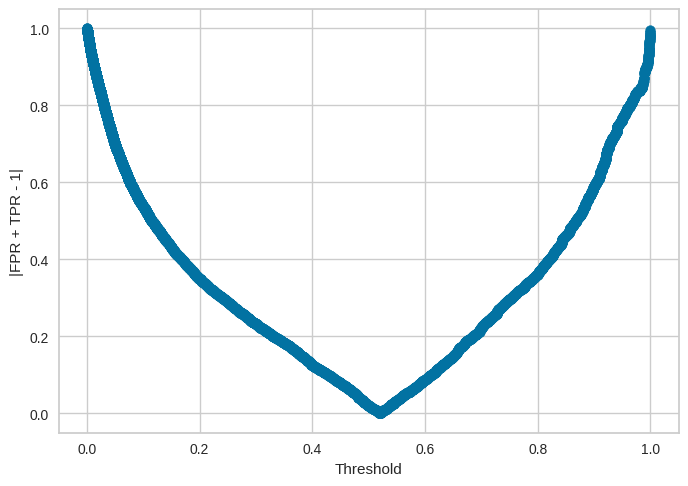

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     13707
           1       0.68      0.55      0.61      5717

    accuracy                           0.79     19424
   macro avg       0.76      0.72      0.74     19424
weighted avg       0.79      0.79      0.79     19424



In [72]:
optimize_threshold(X_train_resort, y_train_resort, X_test_resort, y_test_resort,
                   logreg_cv_resort)

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


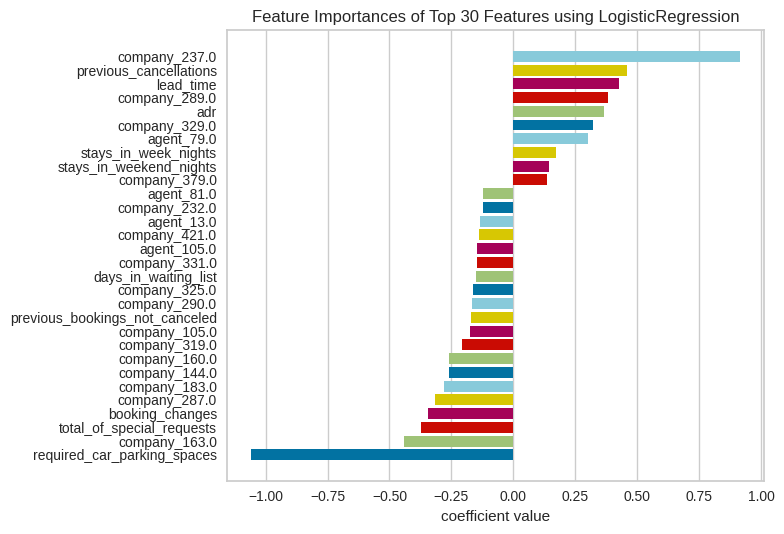

In [80]:
get_top_n_features(logreg_cv_resort, n=30)

## Городские отели

In [73]:
# params_cv_city = optuna_cv(X_train_city, y_train_city)

[I 2025-06-16 18:58:10,533] A new study created in memory with name: no-name-032ef2eb-b88f-4f49-84fa-aef8e160723c
[I 2025-06-16 18:59:24,308] Trial 0 finished with value: 0.5408555746182668 and parameters: {'logreg_c': 9.964126168402142}. Best is trial 0 with value: 0.5408555746182668.
[I 2025-06-16 19:00:24,791] Trial 1 finished with value: 0.6604805768651936 and parameters: {'logreg_c': 0.011571029587293799}. Best is trial 1 with value: 0.6604805768651936.
[I 2025-06-16 19:01:04,912] Trial 2 finished with value: 0.6835464006123214 and parameters: {'logreg_c': 0.0035300542026455075}. Best is trial 2 with value: 0.6835464006123214.
[I 2025-06-16 19:02:12,435] Trial 3 finished with value: 0.570205015963745 and parameters: {'logreg_c': 0.15320873079685612}. Best is trial 2 with value: 0.6835464006123214.
[I 2025-06-16 19:03:18,493] Trial 4 finished with value: 0.5430031452250557 and parameters: {'logreg_c': 1.316737300196691}. Best is trial 2 with value: 0.6835464006123214.
[I 2025-06-16

In [74]:
# save_bnr(params_cv_city, 'binary_files/optuna_cv_city_logreg.pkl')

In [75]:
params_cv_city = load_bnr("binary_files/optuna_cv_city_logreg.pkl")

In [84]:
logreg_cv_city = make_pipeline(StandardScaler(),
                               LogisticRegression(C=params_cv_city.best_params['logreg_c'],
                                                  max_iter=1000,
                                                  class_weight='balanced'))
logreg_cv_city.fit(X_train_city, y_train_city)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.002459319836122507,
                                    class_weight='balanced', max_iter=1000))])

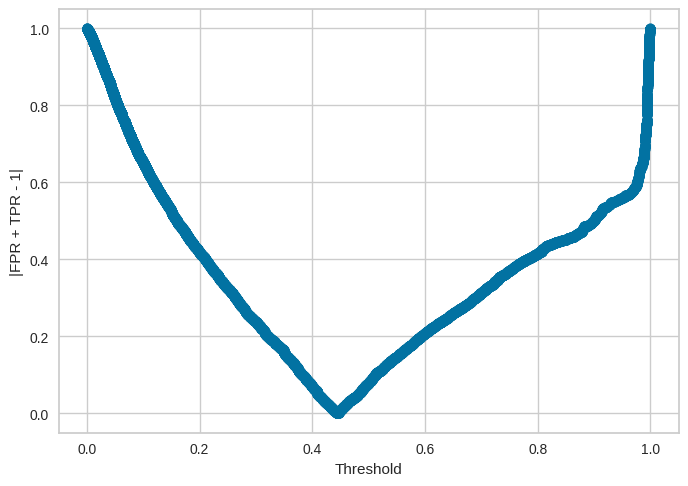

              precision    recall  f1-score   support

           0       0.79      0.86      0.82     23831
           1       0.78      0.70      0.74     17757

    accuracy                           0.79     41588
   macro avg       0.79      0.78      0.78     41588
weighted avg       0.79      0.79      0.79     41588



In [85]:
optimize_threshold(X_train_city, y_train_city, X_test_city, y_test_city,
                   logreg_cv_city)

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


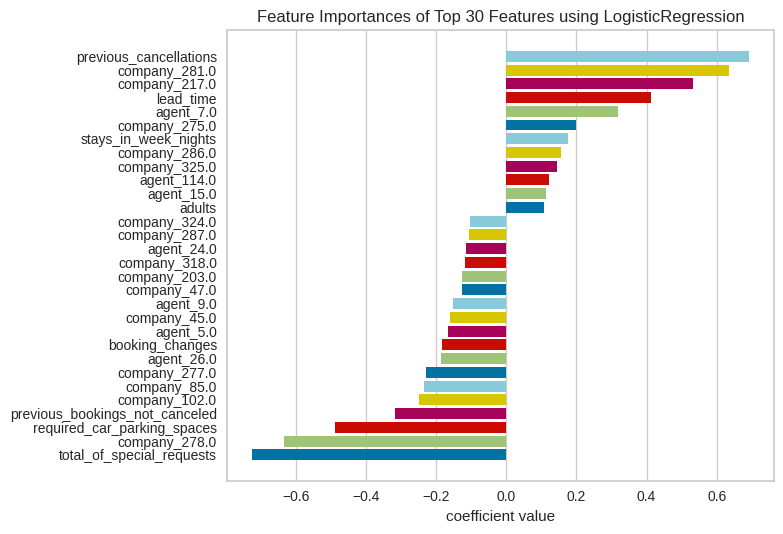

In [86]:
get_top_n_features(logreg_cv_city, n=30)

# Логистическая регрессия:

# LGBMClassifier: без подбора гипер-параметров

## Деление на train_test + LabelEncoding

In [63]:
def preprocess_and_split_labelenc(dataset, target='is_canceled',
                         weeks_2016_train=range(1, 36),
                         weeks_2016_test=range(36, 54),
                         to_drop=None,
                         cat_features=None,
                         numeric_features=None,
                         hotel_remove=False):

    dataset = dataset.copy()

    train_set = dataset[(dataset.arrival_date_year == 2015) |
                       ((dataset.arrival_date_year == 2016) &
                        dataset.arrival_date_week_number.isin(weeks_2016_train))].copy()

    test_set = dataset[((dataset.arrival_date_year == 2016) &
                       dataset.arrival_date_week_number.isin(weeks_2016_test)) |
                       (dataset.arrival_date_year == 2017)].copy()

    y_train = train_set[target].copy()
    y_test = test_set[target].copy()

    if to_drop is None:
        to_drop = []

    columns_to_drop = list(set(to_drop + [target]))
    columns_to_drop = [col for col in columns_to_drop if col in train_set.columns]

    train_features = train_set.drop(columns=columns_to_drop, errors='ignore')
    test_features = test_set.drop(columns=columns_to_drop, errors='ignore')

    if cat_features is None:
        cat_features = []

    if numeric_features is None:
        numeric_features = [col for col in train_features.columns
                          if col not in cat_features]

    if hotel_remove and 'hotel' in cat_features:
        cat_features.remove('hotel')

    cat_features = [col for col in cat_features if col in train_features.columns]
    numeric_features = [col for col in numeric_features if col in train_features.columns]

    X_train = train_features[numeric_features].copy()
    X_test = test_features[numeric_features].copy()

    for col in cat_features:
        le = LabelEncoder()

        combined = pd.concat([train_features[col], test_features[col]])
        le.fit(combined)

        X_train[col] = le.transform(train_features[col])
        X_test[col] = le.transform(test_features[col])

        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

    return X_train, y_train, X_test, y_test

# проверим размеры обучающей и тестовой выборки
def check_shape(X_train, y_train, X_test, y_test, label=None):

    print(label)

    print('Размеры обучающей выборки: ', X_train.shape)
    if len(X_train) != len(y_train):
        print('Размеры таргета и фичей не совпадают')

    print('Размеры тестовой выборки: ', X_test.shape)
    if len(X_test) != len(y_test):
        print('Размеры таргета и фичей не совпадают')
    print('\n')

In [72]:
X_train_hd_b, y_train_hd_b, X_test_hd_b, y_test_hd_b = preprocess_and_split_labelenc(hotel_dataset,
                                                                    target='is_canceled',
                                                                    to_drop=to_drop,
                                                                    cat_features=cat_features,
                                                                    numeric_features=numeric_features)

X_train_resort_b, y_train_resort_b, X_test_resort_b, y_test_resort_b = preprocess_and_split_labelenc(resort_subset,
                                                                    target='is_canceled',
                                                                    to_drop=to_drop,
                                                                    cat_features=cat_features,
                                                                    numeric_features=numeric_features,
                                                                    hotel_remove=True)

X_train_city_b, y_train_city_b, X_test_city_b, y_test_city_b = preprocess_and_split_labelenc(city_subset,
                                                                    target='is_canceled',
                                                                    to_drop=to_drop,
                                                                    cat_features=cat_features,
                                                                    numeric_features=numeric_features,
                                                                    hotel_remove=True)

check_shape(X_train_hd_b, y_train_hd_b, X_test_hd_b, y_test_hd_b,
            label='Данные по всем отелям')
check_shape(X_train_resort_b, y_train_resort_b, X_test_resort_b, y_test_resort_b,
            label='Данные по курортным отелям')
check_shape(X_train_city_b, y_train_city_b, X_test_city_b, y_test_city_b,
            label='Данные по городским отелям')

Данные по всем отелям
Размеры обучающей выборки:  (57890, 24)
Размеры тестовой выборки:  (61012, 24)


Данные по курортным отелям
Размеры обучающей выборки:  (20172, 24)
Размеры тестовой выборки:  (19424, 24)


Данные по городским отелям
Размеры обучающей выборки:  (37718, 24)
Размеры тестовой выборки:  (41588, 24)




## Все отели

In [73]:
lgbm_crossval = LGBMClassifier()

lgbm_crossval.fit(X_train_hd_b, y_train_hd_b)

[LightGBM] [Info] Number of positive: 20683, number of negative: 37207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 57890, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.357281 -> initscore=-0.587185
[LightGBM] [Info] Start training from score -0.587185


LGBMClassifier()

In [74]:
y_preds = lgbm_crossval.predict(X_test_hd_b)
print(classification_report(y_test_hd_b, y_preds))

              precision    recall  f1-score   support

           0       0.77      0.94      0.84     37538
           1       0.85      0.54      0.66     23474

    accuracy                           0.79     61012
   macro avg       0.81      0.74      0.75     61012
weighted avg       0.80      0.79      0.77     61012



In [75]:
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(
    cat_features=cat_features,  # Указываем категориальные колонки
    verbose=100
)

model.fit(X_train_hd_b, y_train_hd_b, eval_set=(X_test_hd_b, y_test_hd_b))

Learning rate set to 0.086352
0:	learn: 0.6103389	test: 0.6364336	best: 0.6364336 (0)	total: 378ms	remaining: 6m 17s
100:	learn: 0.2388956	test: 0.4297039	best: 0.4222476 (18)	total: 17.2s	remaining: 2m 32s
200:	learn: 0.2244135	test: 0.4408306	best: 0.4222476 (18)	total: 32.9s	remaining: 2m 10s
300:	learn: 0.2142482	test: 0.4514107	best: 0.4222476 (18)	total: 49.6s	remaining: 1m 55s
400:	learn: 0.2071271	test: 0.4559237	best: 0.4222476 (18)	total: 1m 5s	remaining: 1m 37s
500:	learn: 0.2008427	test: 0.4610181	best: 0.4222476 (18)	total: 1m 21s	remaining: 1m 21s
600:	learn: 0.1953008	test: 0.4663108	best: 0.4222476 (18)	total: 1m 38s	remaining: 1m 5s
700:	learn: 0.1902848	test: 0.4700419	best: 0.4222476 (18)	total: 1m 55s	remaining: 49.3s
800:	learn: 0.1863349	test: 0.4729759	best: 0.4222476 (18)	total: 2m 11s	remaining: 32.7s
900:	learn: 0.1827834	test: 0.4734161	best: 0.4222476 (18)	total: 2m 31s	remaining: 16.6s
999:	learn: 0.1789853	test: 0.4764180	best: 0.4222476 (18)	total: 2m 53s

In [76]:
y_preds = model.predict(X_test_hd_b)
print(classification_report(y_test_hd_b, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84     37538
           1       0.86      0.53      0.65     23474

    accuracy                           0.79     61012
   macro avg       0.81      0.74      0.75     61012
weighted avg       0.80      0.79      0.77     61012



# Бустинг: кросс-валидация

In [ ]:
import optuna
import sklearn.datasets
import sklearn.linear_model
import sklearn.model_selection

X = X_train_hd
y = y_train_hd
def objective(trial):
    # Предлагаем значение для гиперпараметра C
    # Ищем C в логарифмическом масштабе от 1e-5 до 1e2 (обычная практика для C)
    logreg_c = trial.suggest_float("logreg_c", 1e-5, 1e2, log=True)

    # Создаем модель с предложенным параметром
    model = sklearn.linear_model.LogisticRegression(C=logreg_c, max_iter=1000) # Увеличим max_iter для сходимости

    # Оцениваем модель с помощью кросс-валидации (3 фолда)
    # Используем accuracy как метрику
    score = sklearn.model_selection.cross_val_score(model, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()

    # Возвращаем метрику (accuracy), которую хотим максимизировать
    return accuracy

# 3. Создаем исследование (Study)
# Мы хотим максимизировать accuracy, поэтому direction='maximize'
study = optuna.create_study(direction="maximize")

# 4. Запускаем оптимизацию
# n_trials - количество попыток подбора параметров
study.optimize(objective, n_trials=25)

# Можно получить лучшие параметры и напрямую:
best_params = study.best_params
print("Лучшие параметры в виде словаря:", best_params)